In [236]:
import pandas as pd
import numpy as np
import json
from urllib.parse import unquote_plus
import re
import warnings
from sklearn.preprocessing import normalize
warnings.filterwarnings("ignore")

from scipy.sparse import csr_matrix
import implicit
import lightfm

np.random.seed(42)

## Обработка данных

Загрузим датасеты с исполнителями, пользователями, треками и сессиями прослушиваний. Я выберу 500 пользователей для удобства выполнения операций.

In [2]:
%%time
cols = ['type', 'ID', 'Time', 'Properties', 'Linked']

#entities
# albums = pd.read_csv('albums.idomaar', sep='\t', header=None)
persons = pd.read_csv('persons.idomaar', sep='\t', header=None)
# playlists = pd.read_csv('playlist.idomaar', sep='\t', header=None)
# tags = pd.read_csv('tags.idomaar', sep='\t', header=None)
tracks = pd.read_csv('tracks.idomaar', sep='\t', header=None)
users = pd.read_csv('users.idomaar', sep='\t', header=None)

#relations

# events = pd.read_csv('events.idomaar', sep='\t', header=None)
# love = pd.read_csv('love.idomaar', sep='\t', header=None)
sessions = pd.read_csv('sessions.idomaar', sep='\t', header=None)

Wall time: 40.9 s


In [3]:
users = users.iloc[np.random.randint(0, users.shape[0], 500), :]

entities = {'persons': persons, 'tracks': tracks, 'users': users}
relations = {'sessions': sessions}

Теперь избавимся от дубликатов в таблицах.

In [4]:
%%time

for entity in entities.values():
    entity.columns = cols[:entity.shape[1]]
    entity.drop_duplicates('ID', inplace=True)
    
for relation in relations.values():
    relation.columns = cols[:relation.shape[1]]
    relation.drop_duplicates('ID', inplace=True)

Wall time: 16.2 s


Воспользуемся свойствами наблюдений и вытащим из них фичи.

In [5]:
%%time
sessions['users'] = sessions.iloc[:,3].str.findall('"type":"user","id":(\d*)').str.get(0).astype('int64')
sessions = sessions[sessions.users.isin(users.ID)]

Wall time: 10.2 s


In [6]:
%%time
tracks['person'] = tracks.Linked.str.findall('"id":(\d*)').str.get(0).astype('int64')

Wall time: 9.01 s


In [7]:
%%time
sessions['tracks'] = sessions.loc[:,'Properties'].str.findall('"type":"track","id":(\d*)')
sessions['ratio'] = sessions.loc[:,'Properties'].str.findall('"playratio":(.*?),')
sessions['numtracks'] = sessions.loc[:,'Properties'].str.findall('"numtracks":(.*?),').str.get(0).astype('int')

Wall time: 1.43 s


Теперь составим таблицу, в которой будет информация о каждом прослушанном пользователем треке.

In [8]:
%%time

table = pd.DataFrame(columns=['user', 'track', 'ratio'])

for row in sessions.itertuples():
    for i in range(row[-1]):
        if row[-2][i] != 'null':
            table.loc[table.shape[0]] = [row[-4], int(row[-3][i]), float(row[-2][i])]

table.track = table.track.astype('int')
table.user = table.user.astype('int')

Wall time: 1h 19min 11s


Укажем, какой исполнитель соответствует каждому треку.

In [9]:
%%time
table_merged = table.merge(tracks[['ID', 'Properties', 'person']], left_on='track', right_on='ID')

Wall time: 4.51 s


Теперь построим рекомендательную матрицу "исполнитель-пользователь", где в качестве значений будет сумма долей прослушанных треков во всех сессиях прослушивания.

In [91]:
%%time
grouped_table = pd.pivot_table(table_merged, index='person', columns='user', values='ratio', fill_value=0, aggfunc=sum)

Wall time: 1.08 s


In [93]:
%%time
rec_matrix = csr_matrix(grouped_table)

rec_matrix = rec_matrix[:, rec_matrix.getnnz(0) > 0]

Wall time: 217 ms


## Case Recommender

Для анализа рекомендательной системы сначала обратимся к библиотеке Case Recommender, где реализованы бейзлайновые модели.

In [280]:
import caserec.recommenders.item_recommendation as rec_models

В качестве методов выберем метод Ближайших соседей, модель выбора самых популярных предметов и сокластерный алгоритм PaCo.

In [360]:
from caserec.recommenders.item_recommendation.itemknn import ItemKNN
from caserec.recommenders.item_recommendation.most_popular import MostPopular
from caserec.recommenders.item_recommendation.paco_recommender import PaCoRecommender

Подготавливаем данные, валидируя их. Сразу оговорюсь, что я разбиваю данные на Train / Validation / Test. При этом для Test тренирую модель на Train + Validation, чтобы оценить влияние увеличения данных.

In [312]:
rec_data = table_merged.groupby(by=['user', 'person']).sum()[['ratio']].reset_index()

In [365]:
notest_data = rec_data.sample(frac=0.6, random_state=42)
test_data = rec_data[~rec_data.index.isin(notest_data.index)]

train_data = notest_data.sample(frac=0.6, random_state=42)
val_data = notest_data[~notest_data.index.isin(train_data.index)]

train_data.to_csv('train_data.csv', index=False, header=False, sep='\t')
val_data.to_csv('val_data.csv', index=False, header=False, sep='\t')

notest_data.to_csv('notest_data.csv', index=False, header=False, sep='\t')
test_data.to_csv('test_data.csv', index=False, header=False, sep='\t')

Теперь тренируем модели и смотрим на их результаты. В качестве метрик выбраны Precision, Recall, Mean Average Precision и Normalized Discounted Cumulative Gain.

In [359]:
models_case = {'itemknn': ItemKNN(train_file='train_data.csv', test_file='val_data.csv'),
              'pop': MostPopular(train_file='train_data.csv', test_file='val_data.csv'),
              'paco': PaCoRecommender(train_file='train_data.csv', test_file='val_data.csv')}

In [363]:
%%time

for model_case in models_case.values():
    model_case.compute()

[Case Recommender: Item Recommendation > ItemKNN Algorithm]

train data:: 489 users and 13034 items (23383 interactions) | sparsity:: 99.63%
test data:: 481 users and 9680 items (15589 interactions) | sparsity:: 99.67%

training_time:: 256.445352 sec
prediction_time:: 172.156993 sec


Eval:: PREC@1: 0.014553 PREC@3: 0.011781 PREC@5: 0.010395 PREC@10: 0.006861 RECALL@1: 0.000421 RECALL@3: 0.000727 RECALL@5: 0.000949 RECALL@10: 0.001469 MAP@1: 0.014553 MAP@3: 0.023909 MAP@5: 0.027339 MAP@10: 0.029172 NDCG@1: 0.014553 NDCG@3: 0.033041 NDCG@5: 0.03951 NDCG@10: 0.04431 
[Case Recommender: Item Recommendation > Most Popular]

train data:: 489 users and 13034 items (23383 interactions) | sparsity:: 99.63%
test data:: 481 users and 9680 items (15589 interactions) | sparsity:: 99.67%

prediction_time:: 8.475328 sec


Eval:: PREC@1: 0.008316 PREC@3: 0.01386 PREC@5: 0.009979 PREC@10: 0.017048 RECALL@1: 0.000333 RECALL@3: 0.001111 RECALL@5: 0.001178 RECALL@10: 0.005473 MAP@1: 0.008316 MAP@3: 0.022

Как мы видим, лучшей моделью является выбор самых популярных объектов. Посмотрим, как она себя покажет на тестовой части. Заметим, что подобрать гиперпараметры к этой модели нельзя.

In [394]:
best_model_case = MostPopular(train_file='notest_data.csv', test_file='test_data.csv', rank_length=50)
best_model_case.compute()

[Case Recommender: Item Recommendation > Most Popular]

train data:: 490 users and 18906 items (38972 interactions) | sparsity:: 99.58%
test data:: 489 users and 14252 items (25981 interactions) | sparsity:: 99.63%

prediction_time:: 14.507222 sec


Eval:: PREC@1: 0.018405 PREC@3: 0.025222 PREC@5: 0.039673 PREC@10: 0.029039 RECALL@1: 0.000343 RECALL@3: 0.001235 RECALL@5: 0.00395 RECALL@10: 0.005769 MAP@1: 0.018405 MAP@3: 0.039707 MAP@5: 0.061787 MAP@10: 0.06676 NDCG@1: 0.018405 NDCG@3: 0.059499 NDCG@5: 0.100546 NDCG@10: 0.113977 


Как мы видим, результаты улучшились. Увеличение данных пошло модели на пользу. Теперь попытаемся предсказать 20 артистов для пользователя с ID 664 (здесь и далее все предсказания для этого пользователя).

In [395]:
best_model_case.predict()

In [478]:
print("User ID:", int(knn_rank[70, 0]))

User ID: 664


In [479]:
pop_rank = np.array(best_model_case.ranking)

pop_pers_ID = pop_rank[np.in1d(np.array(pop_rank)[:, 0], pop_rank[70, 0])][:, 1].astype('int64')

pop_pers = np.vectorize(persons[['ID', 'name']].set_index('ID').to_dict()['name'].get)(pop_pers_ID)

index_pers = np.unique(pop_pers, return_index=1)[1]

index_pers.sort()

print('Top 20:')

print(*pop_pers[index_pers][:20], sep=', ')

Top 20:
enigma, shakira & alejandro sanz -, purity ring, coldplay & kylie minogue, the beatles & george martin, arashi, britney spears/stockholm session strings, last lynx, yann tiersen, royal gigolos, vampire weekend, lana del rey, what so not, alt-j ∆, arctic monekys, maximum the hormone, robert delong, lorde & katy perry, florence + the machine, radioheadncon


В этот ответ можно поверить, так как почти все артисты здесь крайне популярны.

Теперь посмотрим, как сильно похожи прогнозы разных моделей. Проведем статистический анализ. Посмотрим на распределения прогнозов для нашего пользователя.

In [410]:
from caserec.evaluation.statistical_analysis import StatisticalAnalysis

In [411]:
models_case['itemknn'].predict()
models_case['pop'].predict()

In [474]:
print("User ID:", int(knn_rank[70, 0]))

User ID: 664


In [475]:
knn_rank = np.array(models_case['itemknn'].ranking)
pop_rank = np.array(models_case['pop'].ranking)

knn_per_one_user = knn_rank[np.in1d(np.array(knn_rank)[:, 0], knn_rank[70, 0])][:, 1:]
pop_per_one_user = pop_rank[np.in1d(np.array(pop_rank)[:, 0], pop_rank[70, 0])][:, 1:]

In [476]:
knn_grid = np.zeros(max(int(knn_per_one_user[:, 0].max()), int(pop_per_one_user[:, 0].max())) + 1)

for i in range(knn_per_one_user.shape[0]):
    knn_grid[int(knn_per_one_user[i, 0])] += knn_per_one_user[i, 1]
    
pop_grid = np.zeros(max(int(knn_per_one_user[:, 0].max()), int(pop_per_one_user[:, 0].max())) + 1)

for i in range(pop_per_one_user.shape[0]):
    pop_grid[int(pop_per_one_user[i, 0])] += pop_per_one_user[i, 1]

Мы проведем тест Вилкоксона о равенстве распределений, так как он не требует условий в виде нормального распределения данных.

In [477]:
stat_an = StatisticalAnalysis(pop_grid, knn_grid, method='wilcoxon')

stat_an.execute()

=== Information About Samples ===
Standard Deviation Sample1: 6.769191092104516
Standard Deviation Sample2: 0.019351283938501083

=== Analyzing the Difference Between Samples ===
SAD:13150.55008854864
SSD:18850621.637397457
Correlation:-2.315567012636268e-05

=== Wilcoxon Analysis ===
The calculated t-statistic: 4.6418055031603694e-07
The two-tailed p-value: 0.9999996296375054



Как мы видим, между прогнозами отсутствует связь, и на любом уровне значимости мы можем отклонить гипотезу о том, что распределения одинаковы. Для оценки значимости одного предсказания можно взять строку пользователя из рекомендательной матрицы и сравнить их распределения.

## Implicit

Теперь рассмотрим библиотеку Implicit, в которой раелизованы разные алгоритмы Collaborative Filtering и методы ближайших соседей на разных мерах. В качестве моделей рассмотрим методы Alternating Least Squares, Bayesian Personal Ranking, Logistic Matrix Factorization и Logistic Matrix Factorization, а также меры косинуса, TF-IDF и BM25. Из доступных метрик в этой библиотеке есть Mean Average Precision, Normalized Discounted Cumulative Gain и AUC. взятые при $k=10$.

In [184]:
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.lmf import LogisticMatrixFactorization
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender, TFIDFRecommender)

from implicit.evaluation import train_test_split, mean_average_precision_at_k, ndcg_at_k, AUC_at_k

Разобьем нашу матрицу и подготовим натренируем модели.

In [185]:
notest_matrix, test_matrix = train_test_split(rec_matrix, train_percentage=0.6)
train_matrix, val_matrix = train_test_split(notest_matrix, train_percentage=0.6)

models = {'als': AlternatingLeastSquares(), 'bpr': BayesianPersonalizedRanking(),
         'lmf': LogisticMatrixFactorization(), 'bm25': BM25Recommender(),
         'cos': CosineRecommender(), 'tf-idf': TFIDFRecommender()}

estimators = {'map': mean_average_precision_at_k, 'ndcg': ndcg_at_k, 'auc': AUC_at_k}

values = {'als': {'map': 0, 'ndcg': 0, 'auc': 0}, 'bpr': {'map': 0, 'ndcg': 0, 'auc': 0},
         'lmf': {'map': 0, 'ndcg': 0, 'auc': 0}, 'bm25': {'map': 0, 'ndcg': 0, 'auc': 0},
         'cos': {'map': 0, 'ndcg': 0, 'auc': 0}, 'tf-idf': {'map': 0, 'ndcg': 0, 'auc': 0}}

In [186]:
%%time

for model in models:
    models[model].fit(train_matrix, show_progress=False)

Wall time: 1.88 s


Теперь оценим модели и посмотрим на результаты.

In [187]:
%%time

for model in models:
    for estimator in estimators:       
        values[model][estimator] = estimators[estimator](models[model], train_matrix.T, val_matrix.T, show_progress=False)

Wall time: 3.88 s


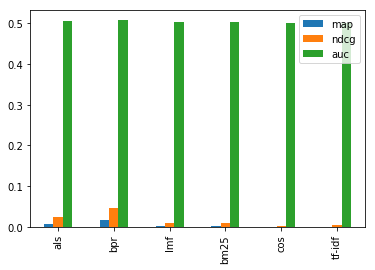

In [188]:
pd.DataFrame(values).T.plot(kind='bar');

Как мы видим, лучшей моделью является Байесовский алгоритм ранжирования, тем не менее, стоит указать на низкие значения метрик. На мой взгляд, они связаны с маленькой выборкой данных. На больших данных результаты будуь лучше.

Теперь посмотрим, как можно развить лучшую модель и подберем ей гиперпараметры.

In [190]:
factors = [10, 50, 100]
iterations = [10, 15, 20]
rates = [0.01, 0.05, 0.1]

grid_models = {num_factor: {num_it: {rate: BayesianPersonalizedRanking(factors=num_factor, learning_rate=rate, \
                    iterations=num_it) for rate in rates} for num_it in iterations} for num_factor in factors}

grid_values = {num_factor: {num_it: {rate: {'map': 0, 'ndcg': 0, 'auc': 0} for rate in rates} \
                            for num_it in iterations} for num_factor in factors}

In [191]:
%%time

for num_factor in factors:
    for num_it in iterations:
        for rate in rates:
            grid_models[num_factor][num_it][rate].fit(train_matrix, show_progress=False)

Wall time: 2.03 s


In [192]:
%%time

for num_factor in factors:
    for num_it in iterations:
        for rate in rates:
            for estimator in estimators:
                grid_values[num_factor][num_it][rate][estimator] = estimators[estimator](grid_models[num_factor][num_it][rate], 
                                                             train_matrix.T, val_matrix.T, show_progress=False)

Wall time: 25.4 s


In [193]:
map_values, ndcg_values, auc_values, grids = [], [], [], []

for num_factor in factors:
    for num_it in iterations:
        for rate in rates:
            grids.append(str(num_factor) + '_' + str(num_it) + '_' + str(rate))
            map_values.append(grid_values[num_factor][num_it][rate]['map'])
            ndcg_values.append(grid_values[num_factor][num_it][rate]['ndcg'])
            auc_values.append(grid_values[num_factor][num_it][rate]['auc'])

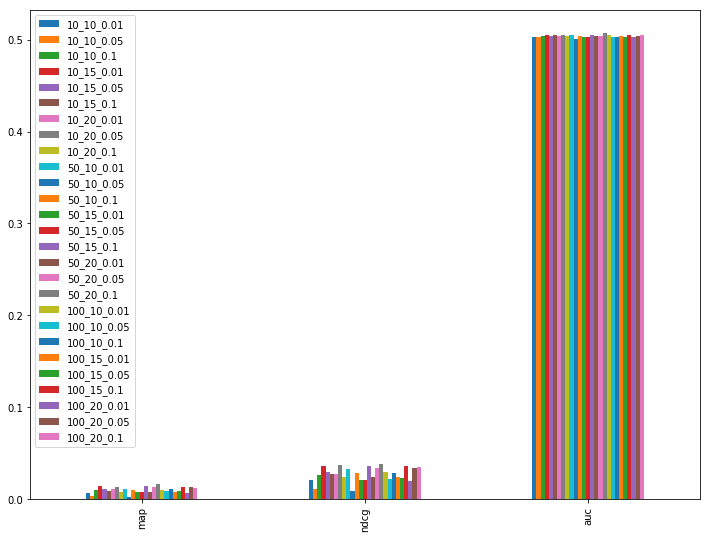

In [194]:
pd.DataFrame([map_values, ndcg_values, auc_values], columns=grids, index=estimators.keys()).plot(kind='bar',
                                                                                        figsize=(12,9));

In [195]:
grid_values[50][20][0.1]

{'map': 0.016078283957981235,
 'ndcg': 0.03776068163280332,
 'auc': 0.5069829103277906}

Итак, мы нашли лучшие параметры, которые улучшили наши результаты. Заметим, что расброс результатов при разных наборе опций примерно одинаковый, что говорит об их незначительности по сравнению с другими недостатками модели как маленькая выборка данных.

Теперь посмотрим на результаты лучшей модели на тестовых данных.

In [198]:
test_values = {'map': 0, 'ndcg': 0, 'auc': 0}

best_model = BayesianPersonalizedRanking(factors=50, learning_rate=0.1, iterations=20)
best_model.fit(notest_matrix, show_progress=False)

for estimator in estimators:
    test_values[estimator] = estimators[estimator](best_model, 
                                                 notest_matrix.T, test_matrix.T, show_progress=False)

test_values

{'map': 0.032612936344969194,
 'ndcg': 0.0754983601439527,
 'auc': 0.5081652742674927}

Как мы видим, результаты улучшились, но они все ещё в разы хуже базового метода. Посмотрим теперь на предсказания.

In [538]:
implicit_pos = np.array(best_model.recommend(grouped_table.columns.get_loc(664), rec_matrix, 20))[:, 0].astype('int64')

implicit_IDs = grouped_table.index[implicit_pos]

implicit_list = np.vectorize(persons[['ID', 'name']].set_index('ID').to_dict()['name'].get)(implicit_IDs)

print('Top 20:')

print(*implicit_list, sep=', ')

Top 20:
m83, dusty springfield, nick drake, damien rice & ray lamontagne, bowie, death cab for cutie, creedence clearwater revival, the raveonettes, neil young & the ducks, paul mccartney & wings - www.musicasparabaixar.org, wild nothing, lou reed & metallica, the shins, cat steven, rolling stones, freelance whales, edward sharpe & the magnetic zeros/the flaming lips, ben howard, arcade fire, ten cc


Значения сильно разнятся с базовым подходом, что крайне сомнительно и говорит о плохом качестве модели. Поэтому все рассмотренные в этой модели библиотеки мы отбрасываем.

## LightFM

Сейчас рассмотрим библиотеку LightFM, которая может подключать дополнительные фичи, связанные с пользователями и артистами. Также, мы рассмотрим ещё одну метрику среднеобратного ранга.

In [106]:
from lightfm import LightFM

In [199]:
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k, reciprocal_rank

Разбиваем данные.

In [203]:
notest_matrix, test_matrix = random_train_test_split(rec_matrix.T, test_percentage=0.4)
train_matrix, val_matrix = random_train_test_split(notest_matrix, test_percentage=0.4)

Теперь создаем фичи о пользователях. Для этого воспользуемся данными о возрасте, плейлистах, времени прослушивания, поле, стране и типу подписки.

In [137]:
users['age'] = users.Properties.str.findall('age":(.*?),').str.get(0).replace('', '-1').astype('int64')
users['playlists'] = users.Properties.str.findall('playlists":(.*?),').str.get(0).replace('', '-1').astype('int64')
users['playcount'] = users.Properties.str.findall('playcount":(.*?),').str.get(0).replace('', '-1').astype('int64')

In [138]:
user_feat = users[['age', 'playcount', 'playlists']]\
               .join([pd.get_dummies(users.Properties.str.findall('gender":"(.*?)"').str.get(0) \
                                .apply(unquote_plus).apply(unquote_plus).str.lower(), drop_first=True),
               pd.get_dummies(users.Properties.str.findall('country":"(.*?)"').str.get(0) \
                                .apply(unquote_plus).apply(unquote_plus), drop_first=True),
               pd.get_dummies(users.Properties.str.findall('subscribertype":"(.*?)"').str.get(0) \
                                .apply(unquote_plus).apply(unquote_plus), drop_first=True)], rsuffix='1').values

Теперь попытаемся добыть информацию о треках. В качестве базовой модели я применил метод TF-IDF к названиям песен.

In [110]:
tracks['name'] = tracks.Properties.str.findall('"name":"(.*?)"').str.get(0) \
                            .apply(unquote_plus).apply(unquote_plus).str.lower().str.split('/_/').str.get(-1)

In [111]:
import nltk
from nltk.corpus import stopwords
sw_eng = set(stopwords.words('english'))

from nltk import WordNetLemmatizer
from nltk import wordnet, pos_tag
from gensim.models import word2vec
from sklearn.feature_extraction.text import TfidfVectorizer

In [112]:
def get_wordnet_pos(treebank_tag):
    
    my_switch = {
        'J': wordnet.wordnet.ADJ,
        'V': wordnet.wordnet.VERB,
        'N': wordnet.wordnet.NOUN,
        'R': wordnet.wordnet.ADV,
    }
    
    for key, item in my_switch.items():
        if treebank_tag.startswith(key):
            return item
    return wordnet.wordnet.NOUN

def my_lemmatizer(sent):
    lemmatizer = WordNetLemmatizer()
    tokenized_sent = sent.split()
    pos_tagged = [(word, get_wordnet_pos(tag))
                 for word, tag in pos_tag(tokenized_sent)]
    return ' '.join([lemmatizer.lemmatize(word, tag)
                    for word, tag in pos_tagged])

def preproc(x):
    lemmas = my_lemmatizer(' '.join([re.sub('[(){}<>-]', '', i).strip('-') \
                                for i in re.split(r'[\n\r\s\d.,&?!*;:]', x.lower()) \
                                if re.sub('[(){}<>]', '', i).strip('-') not in ('', '-')]))
    return ' '.join([i for i in lemmas.split() if i not in sw_eng])

In [132]:
names = np.array([persons.name[persons.ID == x].values[0] for x in grouped_table.index])

In [135]:
%%time
vect_preproc = np.vectorize(preproc)
names = vect_preproc(names)

Wall time: 14.3 s


In [146]:
%%time

tdidf = TfidfVectorizer(stop_words='english')

item_feat = tdidf.fit_transform(names)

Wall time: 220 ms


Теперь рассмотрим две ситуации - с фичами и без. В качестве моделей у нас Bayesian Personalised Ranking, Weighted Approximate-Rank и Logistic Matrix Factorization.

Посмотрим на случай с использованием фич. Сначала натренируем модели.

In [201]:
losses = ['logistic', 'bpr', 'warp', 'warp-kos']

modelsFM = {loss: LightFM(loss=loss) for loss in losses}

estimatorsFM = {'prec': precision_at_k, 'rec': recall_at_k, 'rank': reciprocal_rank}

valuesFM = {loss: {est: 0 for est in estimatorsFM} for loss in losses}

In [204]:
for modelFM in modelsFM.values():
    modelFM.fit(train_matrix, user_features=csr_matrix(user_feat), item_features=item_feat)

Теперь оценим метрики.

In [206]:
%%time

for loss in losses:
    for est in estimatorsFM:
        valuesFM[loss][est] = estimatorsFM[est](modelsFM[loss], val_matrix, train_interactions=train_matrix, 
            user_features=csr_matrix(user_feat), item_features=item_feat).mean()

Wall time: 16.6 s


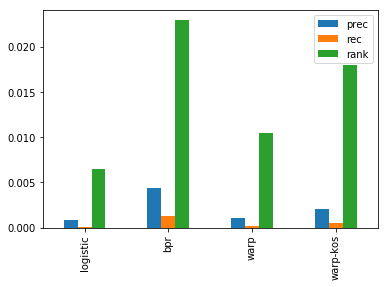

In [207]:
pd.DataFrame(valuesFM).T.plot(kind='bar');

Как мы видим, Байесовский метод тут всех побеждает, но результаты метрик крайне малы. Они не насчитывают даже десятой доли.

Теперь посмотрим на ситуацию, когда фич нет. Совершим все те же действия и посмотрим на результат.

In [208]:
losses = ['logistic', 'bpr', 'warp', 'warp-kos']

modelsFM = {loss: LightFM(loss=loss) for loss in losses}

estimatorsFM = {'prec': precision_at_k, 'rec': recall_at_k, 'rank': reciprocal_rank}

valuesFM = {loss: {est: 0 for est in estimatorsFM} for loss in losses}

In [209]:
for modelFM in modelsFM.values():
    modelFM.fit(train_matrix)

In [211]:
%%time

for loss in losses:
    for est in estimatorsFM:
        valuesFM[loss][est] = estimatorsFM[est](modelsFM[loss], val_matrix, train_interactions=train_matrix).mean()

Wall time: 13.8 s


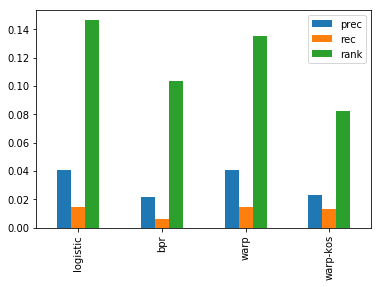

In [212]:
pd.DataFrame(valuesFM).T.plot(kind='bar');

Как можно заметить, результаты значительно улучшились, а лучшей сейчас стала логистическая модель. Подберем под нее гиперпараметры.

In [219]:
no_s_components = [10, 50, 100]
k_s = [5, 10, 15, 20]
n_s = [5, 10, 15, 20]
rates = [0.01, 0.05, 0.1]

grid_models_FM = {no_components: {k: {n: {rate: LightFM(loss='logistic', no_components=no_components, learning_rate=rate, \
                    k=k, n=n) for rate in rates} for n in n_s} for k in k_s} for no_components in no_s_components}

grid_values_FM = {no_components: {k: {n: {rate: {est: 0 for est in estimatorsFM} \
                                          for rate in rates} for n in n_s} for k in k_s} for no_components in no_s_components}

In [222]:
%%time

for no_components in no_s_components:
    for k in k_s:
        for n in n_s:
            for rate in rates:
                grid_models_FM[no_components][k][n][rate].fit(train_matrix)

Wall time: 33.1 s


In [228]:
%%time

for no_components in no_s_components:
    for k in k_s:
        for n in n_s:
            for rate in rates:
                for est in estimatorsFM:
                    grid_values_FM[no_components][k][n][rate][est] = estimatorsFM[est](\
                                grid_models_FM[no_components][k][n][rate],
                                val_matrix, train_interactions=train_matrix).mean()

Wall time: 18min 7s


In [229]:
prec_values, rec_values, rank_values, grids_FM = [], [], [], []

for no_components in no_s_components:
    for k in k_s:
        for n in n_s:
            for rate in rates:
                grids_FM.append(str(no_components) + '_' + str(k) + '_' + str(n) + '_' + str(rate))
                prec_values.append(grid_values_FM[no_components][k][n][rate]['prec'])
                rec_values.append(grid_values_FM[no_components][k][n][rate]['rec'])
                rank_values.append(grid_values_FM[no_components][k][n][rate]['rank'])

Теперь посмотрим на них.

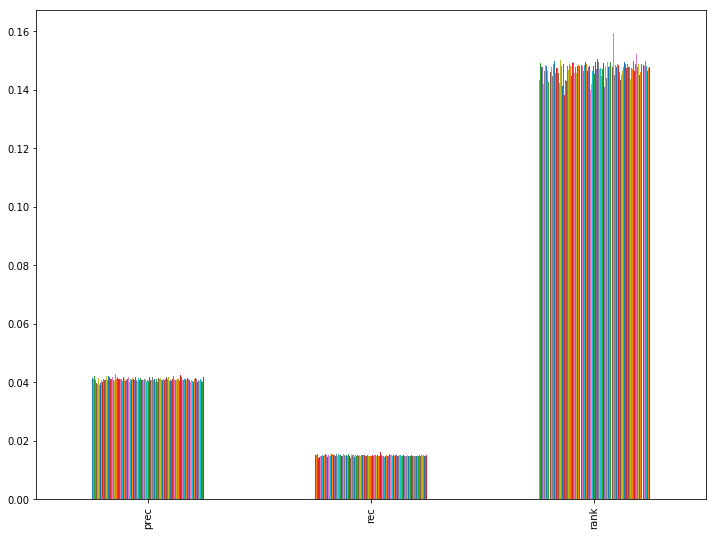

In [258]:
pd.DataFrame([prec_values, rec_values, rank_values], columns=grids_FM, index=estimatorsFM.keys()).plot(kind='bar',
                                                                                        figsize=(12,9), legend=False);

Нельзя однозначно сказать, какая модель лучше по графику, поэтому выберем лучшую модель из среднего по нормализованным метрикам.

In [274]:
grids_FM[normalize(np.array([prec_values, rec_values, rank_values])).mean(axis=0).argmax()]

'50_15_20_0.1'

In [275]:
grid_values_FM[50][15][20][0.1]

{'prec': 0.04273859, 'rec': 0.01636519989670398, 'rank': 0.14900239}

Результаты обновленной модели улучшились по сравнению с состоянием "до". А теперь посмотрим на результаты на тестовой части.

In [277]:
test_values_FM = {'prec': 0, 'rec': 0, 'rank': 0}

best_model_FM = LightFM(loss='logistic', no_components=50, learning_rate=0.1, k=15, n=20)
best_model_FM.fit(notest_matrix)

for estimator in estimatorsFM:
    test_values_FM[estimator] = estimatorsFM[estimator](best_model_FM, test_matrix, train_interactions=notest_matrix).mean()

test_values_FM

{'prec': 0.07276423, 'rec': 0.01646463538614045, 'rank': 0.19166632}

Они показали большой рост в двух метриках и маленький в третьей, что говорит о том, что увеличение данных улучшило нашу модель.

Теперь выберем 20 исполнителей для нашего пользователя из этой модели.

In [522]:
persons_pos = best_model_FM.predict(user_ids=grouped_table.columns.get_loc(664), 
                      item_ids=np.unique(grouped_table.index, return_index=1)[1]).argsort()[::-1][:20]

In [526]:
persons_IDs = grouped_table.index[persons_pos]

persons_list = np.vectorize(persons[['ID', 'name']].set_index('ID').to_dict()['name'].get)(persons_IDs)

print('Top 20:')

print(*persons_list, sep=', ')

Top 20:
daft punk & sander kleinenberg, coldplay & kylie minogue, radioheadncon, arctic monekys, lana del rey, lorde & katy perry, muse - absolution, bowie, the beatles & george martin, sandie shaw and the smiths, linkin park & jay-z (live clean), katy perry ft juicy j, pink floyd & floyd, rolling stones, queen & the muppets, foo figthers, arcade fire, mgmt, the black keys, madonna feat. nicki minaj


Данные результаты похожи на бейзлайновую модель, что говорит о том, что модель имеет смысл.

Дополнительные данные можно использовать для рахных целей. Из данных об альбомах и песнях можно генерировать больше фич для исполнителя, а их плейлистов - для пользователя. Из сессий, лайков и событий можно сделать три отдельные рекомендательные матрицы и вместе группой их обрабатывать. Также можно динамически пытаться предсказывать следующий трек или артиста, которого захочет послушать пользователь. Данные из песенных названий, плейлистов, совместных треков, тегов и событий можно использовать для создания матриц похожести, которые тоже можно привлекать в качестве фич в модели.